# Multi-sample

Run all cells to:
- Import data for the Reyngold, Aurora, and Desmedt paired-sample data cohorts
- Calculate correlation between samples
- Calculate $c_\beta$ for samples
- Create all plots relating to these cohorts

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import colormaps
import matplotlib.pyplot as plt
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts
from math import sqrt

In [3]:
## Data dictionaries
## Hold certain types of data objects, accessible by cohort name

beta_values = {}                    # Dataframe of Clock beta values (500 CpGs by n samples)
sample_map = {}                     # Dataframe with samples as index and columns as features (patient ID, sample type, etc.)
patients_bothSamplesPure = {}       # List of patients to use
samples_from_purePairs = {}         # Paired samples to be used from patients in patients_bothSamplesPure 
correlation_df = {}                 # Dataframe (n x n) of R-values (correlation of samples' Clock beta values)

## DELETE
# LUMP_purity = {}                    # Series of LUMP purity values for each sample

## Set up output directories for figures
figure_outdir = os.path.join('figures', 'multi-sample')
os.makedirs(figure_outdir, exist_ok=True)

In [4]:
## Configure graph
sf = consts['sf']
square_figsize = np.array([5, 4])
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

# Heatmap colormap
cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)

## Primary-metastasis samples

### Import and process data

In [4]:
proj_dir_reyn = os.path.join(consts['official_indir'], 'Reyngold')
proj_dir_auro = os.path.join(consts['official_indir'], 'Aurora')

##################
#######  Reyngold
##################

sample_map['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'sample_map.txt'), index_col=0)
sample_map['Reyngold'] = sample_map['Reyngold'].rename(columns={'unique patient id':'Patient', 'sample type':'Sample Type'})
sample_map['Reyngold']['Sample Type'] = sample_map['Reyngold']['Sample Type'].map({'primary tumor':'Primary', 'lymph node metastasis':'Metastasis'})
patients_bothSamplesPure['Reyngold'] = np.loadtxt(os.path.join(proj_dir_reyn, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Reyngold'] = sample_map['Reyngold'].index[sample_map['Reyngold']['Patient'].isin(patients_bothSamplesPure['Reyngold'])].values

## DELETE
# LUMP_purity['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'LUMP_purity.txt'), index_col=0).squeeze('columns')

##################
#######  Aurora
##################

sample_map['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'sample_map.txt'), index_col=0)
patients_bothSamplesPure['Aurora'] = np.loadtxt(os.path.join(proj_dir_auro, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'beta_values_Clock_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Aurora'] = sample_map['Aurora'].index[sample_map['Aurora']['Patient'].isin(patients_bothSamplesPure['Aurora'])].values

## DELETE
# LUMP_purity['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'LUMP_purity.txt'), index_col=0).squeeze('columns')

##################
#######  Combine the two cohorts
##################

sample_map['combined'] = pd.concat([sample_map['Reyngold'], sample_map['Aurora']], axis=0)
patients_bothSamplesPure['combined'] = np.concatenate([patients_bothSamplesPure['Reyngold'], patients_bothSamplesPure['Aurora']])
beta_values['combined'] = pd.concat([beta_values['Reyngold'], beta_values['Aurora']], axis=1)
samples_from_purePairs['combined'] = np.concatenate([samples_from_purePairs['Reyngold'], samples_from_purePairs['Aurora']])

## DELETE
# LUMP_purity['combined'] = pd.concat([LUMP_purity['Reyngold'], LUMP_purity['Aurora']], axis=0)

for cohort in sample_map:
    print(f'{cohort}: {len(patients_bothSamplesPure[cohort])} patients')

Reyngold: 18 patients
Aurora: 22 patients
combined: 40 patients


### Calculate correlation

In [5]:
def getCorrelationDF(samples_from_purePairs, beta_values, sample_map):
    """
    Return dataframe of Pearson correlation R-values between samples
    Compare beta_values of each sample
    Formats row and column names to be "[Patient ID]: [Type]"
    """
    
    correlation_df = pd.DataFrame(index=samples_from_purePairs, columns=samples_from_purePairs, data=float('nan'))
    n_GSMs = correlation_df.shape[0]

    for i in range(n_GSMs):
        GSM_i = samples_from_purePairs[i]
        correlation_df.loc[GSM_i, GSM_i] = 1
        for j in range(i+1, n_GSMs):
            GSM_j = samples_from_purePairs[j]
            res = epi_util.pearsonCorrelation(beta_values[GSM_i], beta_values[GSM_j])
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue
    
    # Create copy for the purposes of transforming the sample IDs to "[Patient ID]: [Type]"
    sample_map_copy = sample_map[['Patient', 'Sample Type']].copy()
    sample_map_copy['Sample Type'] = sample_map_copy['Sample Type'].map({'Primary':'Tum', 'Metastasis':'Met'})
    GSM_to_heatmap_label_mapper = sample_map_copy.loc[samples_from_purePairs].apply(lambda x:': '.join(x), axis=1)
    correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

    return correlation_df

correlation_df['Reyngold'] = getCorrelationDF(samples_from_purePairs['Reyngold'], beta_values['Reyngold'], sample_map['Reyngold'])
correlation_df['Aurora'] = getCorrelationDF(samples_from_purePairs['Aurora'], beta_values['Aurora'], sample_map['Aurora'])
correlation_df['combined'] = getCorrelationDF(samples_from_purePairs['combined'], beta_values['combined'], sample_map['combined'])

### Plot correlation

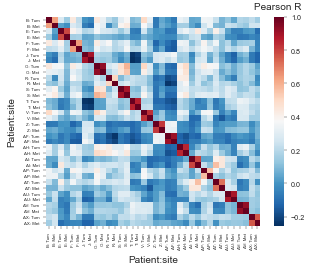

In [7]:
##################
cohort = 'Reyngold'
##################

# Create plot
fig, ax = plt.subplots(figsize=square_figsize * 2.4 * sf)
sns.heatmap(ax=ax, data=correlation_df[cohort], cmap=cmap, cbar_kws={'label':'Pearson R'})

# Customize colorbar
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(consts['labelfontsize'] * sf)
cbar_ax.tick_params(labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

# Customize figure
ax.set_xlabel('Patient:site', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Patient:site', fontsize=consts['labelfontsize'] * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * 0.6 * sf, width=sf, length=8 * sf)

# Need to fix ticks in this weird way
#    to make sure that they are all written on the plot
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df[cohort].index)
ax.set_yticks(ticks, correlation_df[cohort].index)

# Save figure
fig.savefig(os.path.join(figure_outdir, f'{cohort}_prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

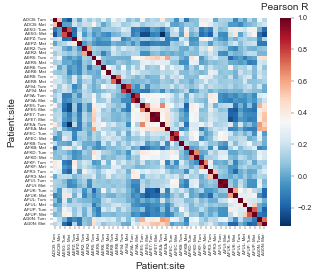

In [8]:
##################
cohort = 'Aurora'
##################

# Create plot
fig, ax = plt.subplots(figsize=square_figsize * 2.4 * sf)
sns.heatmap(ax=ax, data=correlation_df[cohort], cmap=cmap, cbar_kws={'label':'Pearson R'})

# Customize colorbar
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(consts['labelfontsize'] * sf)
cbar_ax.tick_params(labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

# Customize figure
ax.set_xlabel('Patient:site', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Patient:site', fontsize=consts['labelfontsize'] * sf)
ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_label_coords(-0.17, 0.5)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * 0.6 * sf, width=sf, length=8 * sf)

# Need to fix ticks in this weird way
#    to make sure that they are all written on the plot
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1, ax.get_xticks() + 2]))[:-1]
ax.set_xticks(ticks, correlation_df[cohort].index)
ax.set_yticks(ticks, correlation_df[cohort].index)

# Save figure
fig.savefig(os.path.join(figure_outdir, f'{cohort}_prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

### Correlation statistics

In [9]:
def statisticsCorrelationDF(correlation_df):
    """
    Use correlation_df to calculate some statistics
    Calculates lists of between-patient correlations and same-patient correlations (R-values)
    Returns medians of both and the Wilcoxon rank-sums p-value comparing them
    """
    same_patient_r = []
    diff_patient_r = []

    samples = correlation_df.index
    n_samps = len(samples)
    for i in range(n_samps - 1):
        samp_i = samples[i]
        patient_i = samp_i.split(':')[0]
        for j in range(i + 1, n_samps):
            samp_j = samples[j]
            patient_j = samp_j.split(':')[0]
            rvalue = correlation_df.loc[samp_i, samp_j]

            if patient_i == patient_j:
                same_patient_r.append(rvalue)
            else:
                diff_patient_r.append(rvalue)

    pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue
    return np.median(same_patient_r), np.median(diff_patient_r), pvalue

## Print statistics in both cohorts (and combined)

med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['Reyngold'])

print('Reyngold')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')

med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['Aurora'])

print('Aurora')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')


med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['combined'])

print('Combined')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')

Reyngold
	Median within-patient correlation: 0.82
	Median between-patient correlation: 0.14
	Wilcoxon rank sum test: P = 5e-13
Aurora
	Median within-patient correlation: 0.66
	Median between-patient correlation: 0.10
	Wilcoxon rank sum test: P = 3e-14
Combined
	Median within-patient correlation: 0.73
	Median between-patient correlation: 0.08
	Wilcoxon rank sum test: P = 2e-26


### Plot $c_\beta$ of primary vs. metatastis

In [10]:
## Create dataframe of c_beta values for the sample pair for each patient
cohort = 'combined'

c_beta = 1 - beta_values[cohort].std(axis=0)
c_beta_by_patient = sample_map[cohort].reset_index().pivot(index='Patient', columns='Sample Type', values='index')
c_beta_by_patient['Metastasis'] = c_beta_by_patient['Metastasis'].map(c_beta)
c_beta_by_patient['Primary'] = c_beta_by_patient['Primary'].map(c_beta)
c_beta_by_patient = c_beta_by_patient.loc[patients_bothSamplesPure[cohort]]

## DELETE
# LUMP_purity_by_patient = sample_map[cohort].reset_index().pivot(index='Patient', columns='Sample Type', values='index').loc[patients_bothSamplesPure[cohort]]
# LUMP_purity_by_patient['Primary'] = LUMP_purity_by_patient['Primary'].map(LUMP_purity[cohort])
# LUMP_purity_by_patient['Metastasis'] = LUMP_purity_by_patient['Metastasis'].map(LUMP_purity[cohort])

Primary older       36
Metastasis older     4
dtype: int64

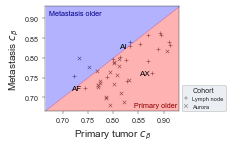

In [147]:
# Plot parameters
marker_s = consts['s'] * 0.6
lw = 1.5

# Create plot axis
fig, ax = plt.subplots(figsize=square_figsize * 1.2 * sf)

# Plot tumors
marker_dict = {'Reyngold':'+', 'Aurora':'x'}
label_dict = {'Reyngold':'Lymph node', 'Aurora':'Aurora'}
for crt in ['Reyngold', 'Aurora']:
    plot_df = c_beta_by_patient.loc[patients_bothSamplesPure[crt]]
    ax.scatter(plot_df['Primary'], plot_df['Metastasis'], s=marker_s * sf, marker=marker_dict[crt], color='dimgray', linewidths=lw * sf)

# Color fill
pts_range = (c_beta_by_patient.min().min()*0.98, c_beta_by_patient.max().max()*1.02)
ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

# Create legend
patches = [mlines.Line2D([], [], color='dimgray', marker=marker_dict[crt], linestyle='None',
                         markersize=sqrt(marker_s) * 1.5 * sf, markeredgewidth=lw * 0.75 * sf, linewidth=lw * 100 * sf, label=label_dict[crt])
           for crt in marker_dict.keys()]
fig.legend(
    handles=patches, loc='lower left', bbox_to_anchor=(0.9, 0.1),
    fontsize=consts['ticksfontsize'] * 0.8 * sf, title_fontsize=consts['ticksfontsize'] * sf, frameon=True, title='Cohort',
    facecolor='#e6eaf0', handlelength=0.5
)

# Customize figure
ax.set_xlabel('Primary tumor $c_β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Metastasis $c_β$', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

# Custom text on plot
ax.text(pts_range[0]*1.01, pts_range[1]*0.99, 'Metastasis older',
        ha="left", va="top", fontfamily='sans-serif', color='darkblue',
        fontsize=consts['ticksfontsize'] * sf)
ax.text(pts_range[1]*0.995, pts_range[0]*1.01, 'Primary older',
        ha="right", va="bottom", fontfamily='sans-serif', color='darkred',
        fontsize=consts['ticksfontsize'] * sf)

# Label 3 patients
for patient in ['AF', 'AX', 'AI']:
    xpos = c_beta_by_patient.loc[patient, 'Primary']
    ypos = c_beta_by_patient.loc[patient, 'Metastasis']
    ax.text(xpos-0.006, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=consts['labelfontsize'] * 0.8 * sf)

# Save figure
fig.savefig(os.path.join(figure_outdir, f'{cohort}_prim-met_age_comparison.pdf'), format='pdf', pad_inches=0.1)

# Display number of tumors where primary older than metastasis, or vice versa
age_differential = (c_beta_by_patient['Primary'] > c_beta_by_patient['Metastasis']).value_counts()
age_differential.index = age_differential.index.map({True:'Primary older', False:'Metastasis older'})
display(age_differential)

### Plot correlation vs. age difference

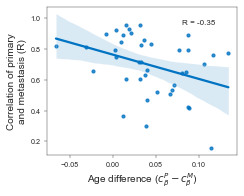

In [72]:
# Store R-values of each patient (prim vs met)
rvalue_list = [correlation_df[cohort].loc[f'{patient}: Tum', f'{patient}: Met'] for patient in patients_bothSamplesPure[cohort]]
rvalue_ser = pd.Series(index=patients_bothSamplesPure[cohort], data=rvalue_list).rename('R')

# Store difference in c_beta values (prim vs met)
c_beta_diff = (c_beta_by_patient['Primary'] - c_beta_by_patient['Metastasis']).rename('c_beta_diff')

# Format plot data
plot_data = pd.concat([rvalue_ser, c_beta_diff], axis=1)

# Create plot
fig, ax = plt.subplots(figsize=square_figsize * 1.7 * sf)
sns.regplot(ax=ax, data=plot_data, x='c_beta_diff', y='R', color=consts['palette_jco'][0], scatter_kws={'s':consts['s'] * 0.5 * sf})

# Customize figure
ax.set_xlabel('Age difference ($c_β^P - c_β^M$)', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Correlation of primary\nand metastasis (R)', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Calculate R value to display on graph
R = epi_util.pearsonCorrelation(plot_data['c_beta_diff'], plot_data['R']).rvalue
ax.text(0.1, 0.95, f'R = {R:.2f}',
        ha="center", va="bottom", fontfamily='sans-serif',
        fontsize=0.8 * labelfontsize * sf)

# Save figure
fig.savefig(os.path.join(figure_outdir, f'{cohort}_prim-met_corr_vs_age_diff.pdf'), format='pdf', pad_inches=0.1)

### Plot beta value distributions of three example patients from Reyngold cohort

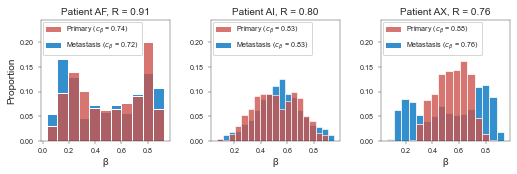

In [230]:
patient_list = ['AF', 'AI', 'AX']
ncols = len(patient_list)
nrows = 1

# Create plot
fig, axes = plt.subplots(nrows, ncols, figsize=figsize * [2, 0.8] * sf)
fig.tight_layout(pad=0.7)

# Colors to use
color_dict = {'primary':consts['palette_jco'][3], 'metastasis':consts['palette_jco'][0]}

for i, patient in enumerate(patient_list):
    
    # Sample IDs of the patient
    samp_prim = sample_map['Reyngold'].index[(sample_map['Reyngold']['Patient'] == patient) & (sample_map['Reyngold']['Sample Type'] == 'Primary')].values[0]
    samp_met = sample_map['Reyngold'].index[(sample_map['Reyngold']['Patient'] == patient) & (sample_map['Reyngold']['Sample Type'] == 'Metastasis')].values[0]
    
    # Create beta values dataframe with two columns
    df_prim = beta_values['Reyngold'][samp_prim].rename('beta').to_frame()
    df_met = beta_values['Reyngold'][samp_met].rename('beta').to_frame()
    df_prim['Sample Type'] = 'primary'
    df_met['Sample Type'] = 'metastasis'
    df = pd.concat([df_prim, df_met], axis=0, ignore_index=True)
    
    col = i % ncols
    ax = axes[col]
    sns.histplot(ax=ax, data=df, x='beta', hue='Sample Type', common_norm=False, legend=False, stat='proportion',
                 palette=color_dict, alpha=consts['opacity'])
    
    # Only write y-axis label on left plot
    if i == 0:
        ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    
    
    # Create legend
    patches = [mpatches.Patch(color=color_dict['primary'], label=f'Primary ($c_β$ = {c_beta_by_patient.loc[patient, "Primary"]:.2f})',
                              alpha=consts['opacity'], linewidth=0),
               mpatches.Patch(color=color_dict['metastasis'], label=f'Metastasis ($c_β$ = {c_beta_by_patient.loc[patient, "Metastasis"]:.2f})',
                              alpha=consts['opacity'], linewidth=0)]
    plots_x, plots_y = ax.get_position().get_points()[1]
    ax.legend(handles=patches,
       loc='center',
       bbox_to_anchor=(0.4, 0.85),
       fontsize=consts['ticksfontsize'] * sf,
       frameon=True
      )
    
    # Customize figure and plot R value in title of each plot
    rvalue = epi_util.pearsonCorrelation(df_prim['beta'], df_met['beta']).rvalue
    ax.set_xlabel('β', fontsize=consts['labelfontsize'] * sf)
    ax.set_title(f'Patient {patient}, R = {rvalue:.2f}', fontsize=consts['labelfontsize'] * sf)
    ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
    ax.set_ylim(0, 0.245)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'prim-met-hists.pdf'), format='pdf', pad_inches=0.1)

## Bifocal tumor samples

### Import and process data

In [7]:
proj_dir = os.path.join(consts['official_indir'], 'Desmedt')

##################
#######  Desmedt
##################

sample_map['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=0, dtype=str)
patients_bothSamplesPure['Desmedt'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Desmedt'] = sample_map['Desmedt'].index[sample_map['Desmedt']['patient'].isin(patients_bothSamplesPure['Desmedt'])].values

In [14]:
# correlation_df = pd.DataFrame(index=samples_from_purePairs['Desmedt'], columns=samples_from_purePairs['Desmedt'], data=float('nan'))
# n_GSMs = correlation_df.shape[0]

# for i in range(n_GSMs):
#     GSM_i = samples_from_purePairs['Desmedt'][i]
#     correlation_df.loc[GSM_i, GSM_i] = 1
#     for j in range(i+1, n_GSMs):
#         GSM_j = samples_from_purePairs['Desmedt'][j]
#         ser_i = beta_values['Desmedt'][GSM_i]
#         ser_j = beta_values['Desmedt'][GSM_j]
#         res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
#         if n_used >= 10:
#             correlation_df.loc[GSM_i, GSM_j] = res.rvalue
#             correlation_df.loc[GSM_j, GSM_i] = res.rvalue

# GSM_to_heatmap_label_mapper = sample_map['Desmedt'].loc[samples_from_purePairs['Desmedt'], ['patient', 'foci']].apply(lambda x:':'.join(x), axis=1)
# correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

### Calculate correlation

In [15]:
correlation_df['Desmedt'] = getCorrelationDF(samples_from_purePairs['Desmedt'], beta_values['Desmedt'], sample_map['Desmedt'])

### Plot correlation

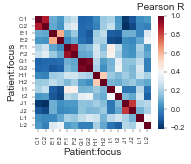

In [17]:
# Create plot
fig, ax = plt.subplots(figsize=square_figsize * 1.3 * sf)
sns.heatmap(ax=ax, data=correlation_df['Desmedt'], cmap=cmap, cbar_kws={'label':'Pearson R'})

# Customize colorbar
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(consts['labelfontsize'] * sf)
cbar_ax.tick_params(labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.11)

# Customize figure
ax.set_xlabel('Patient:focus', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Patient:focus', fontsize=consts['labelfontsize'] * sf)
ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_label_coords(-0.16, 0.5)

# Need to fix ticks in this weird way
#    to make sure that they are all written on the plot
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * 0.8 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df['Desmedt'].index)
ax.set_yticks(ticks, correlation_df['Desmedt'].index)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'bifocal_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [142]:
# DELETE

# ## Significant difference between between-patient correlations and same-patient correlations

# same_patient_r = []
# diff_patient_r = []

# samples = correlation_df['Desmedt'].index
# n_samps = len(samples)
# for i in range(n_samps - 1):
#     samp_i = samples[i]
#     patient_i = samp_i.split(':')[0]
#     for j in range(i + 1, n_samps):
#         samp_j = samples[j]
#         patient_j = samp_j.split(':')[0]
#         rvalue = correlation_df['Desmedt'].loc[samp_i, samp_j]
        
#         if patient_i == patient_j:
#             same_patient_r.append(rvalue)
#         else:
#             diff_patient_r.append(rvalue)

# pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue

# print(f'Median within-patient correlation: {np.median(same_patient_r):.2f}')
# print(f'Median between-patient correlation: {np.median(diff_patient_r):.2f}')
# print(f'Wilcoxon rank sum test: P = {pvalue:.0e}')

## Print statistics in both cohorts (and combined)

med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['Desmedt'])

print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')

Median within-patient correlation: 0.72
Median between-patient correlation: 0.10
Wilcoxon rank sum test: p = 3e-06


### Plot $c_\beta$ of primary vs. metatastis

In [83]:
## Create dataframe of c_beta values for the sample pair for each patient

c_beta = 1 - beta_values['Desmedt'].std(axis=0)
c_beta_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index').loc[patients_bothSamplesPure['Desmedt']]
c_beta_by_patient['1'] = c_beta_by_patient['1'].map(c_beta)
c_beta_by_patient['2'] = c_beta_by_patient['2'].map(c_beta)

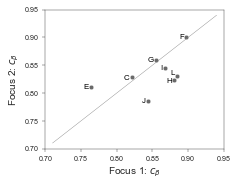

In [93]:
# Create plot axis
fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# Range of x-axis and y-axis
pts_range = (0.7, 0.95)

# Array of values to plot for the identity line
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)
ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

# Plot tumors
sns.scatterplot(ax=ax, data=c_beta_by_patient, x='1', y='2', color='dimgray', s=consts['s'] * sf)

# Customize figure
ax.set_xlabel('Focus 1: $c_β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Focus 2: $c_β$', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

# Y-coord offset for patient labels
offset_y = {'L':0.005}

# Label points with patient IDs
for patient in c_beta_by_patient.index:
    xpos = c_beta_by_patient.loc[patient, '1']
    ypos = c_beta_by_patient.loc[patient, '2']
    if patient in offset_y:
        ypos += offset_y[patient]
    ax.text(xpos-0.003, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=consts['labelfontsize'] * 0.8 * sf)

# Save figure
plt.savefig(os.path.join(figure_outdir, 'bifocal_age_comparison.pdf'), format='pdf')